<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.HousePrices/blob/FeatureAnalysis/House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objectives:
1. Learn important feature selection
- SelectKBest from scikit learn
- Correlation matrix
- Feature importance from classifiers

# **0. Packages, constants and Functions**

## Packages

In [126]:
import pandas as pd
import numpy as np
from google.colab import drive

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Printing
import pprint

# Feature selection
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

# Encoding
from sklearn.preprocessing import OrdinalEncoder

## Constants

In [127]:
train_proportion = 0.8
validation_proportion = 0.2
rand_state = 42

# Feature selection
select_k_numerics = 20  # select 20 out of 36 numeric features

## Functions

In [128]:
def nan_statistics(df, nan_thresh=0.4):
    res = {}
    nan_cols = df.loc[:, df.isnull().any()].columns
    for col in nan_cols:
        res[col] = nan_percentage(df, col)
    print(f'Col -- Nan percentage')
    for key, val in sorted(res.items(), key=lambda item: item[1], reverse=True):
        if val >= nan_thresh * 100:
            print(key, val)

def nan_percentage(df, colname):
    return (df[colname].isnull().sum() / df.shape[0]) * 100

def corr_filter(corr_matrix, target_feature, abs_thresh=0.3):
    res = {}
    series = corr_matrix[target_feature]
    for idx, val in series.items():
        if abs(val) >= abs_thresh:
            res[idx] = val  # Feature names and corr coeff
    return res

def print_unique_dtypes(df):
    print(set(train.dtypes.values))


## Data download

In [129]:
# Setting file download from google Drive

drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'
df_path = 'ML/Datasets/2.HousePrices/'

train_path = gdrive_path + df_path + "train.csv"
test_path =  gdrive_path + df_path + "test.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [130]:
train = pd.read_csv(train_path, index_col='Id')
test = pd.read_csv(test_path, index_col='Id')
target = train['SalePrice']

# **1. Feature exploration**

## **1.1. Nan statistics & target dist**

In [131]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


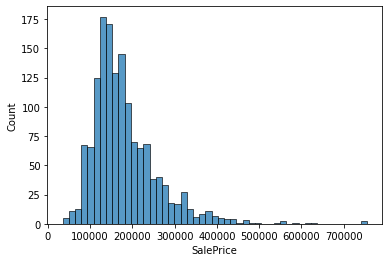

In [132]:
# Check price dist in train
sns.histplot(train['SalePrice'])

In [133]:
nan_statistics(train, nan_thresh=0.4)

Col -- Nan percentage
PoolQC 99.52054794520548
MiscFeature 96.30136986301369
Alley 93.76712328767123
Fence 80.75342465753424
FireplaceQu 47.26027397260274


In [134]:
nan_statistics(test, nan_thresh=0.4)

Col -- Nan percentage
PoolQC 99.7943797121316
MiscFeature 96.50445510623715
Alley 92.66620973269363
Fence 80.12337217272105
FireplaceQu 50.03427004797807


**Insight #1: Remove features with Nans > 40% (PoolQC, MiscFeature, Alley, Fence, FireplaceQu)**

## **1.2. Select K best numerics**

In [135]:
# Choose numeric types and try SelectKBest features
train_numeric = train.select_dtypes(include=['float64', 'int64'])

train_numeric.drop(columns=['SalePrice'], inplace=True)
train_numeric.fillna(train_numeric.median(), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [136]:
features_selector = SelectKBest(score_func=chi2, k=select_k_numerics)
fit = features_selector.fit(train_numeric, target)

In [137]:
feature_scores = pd.DataFrame({
    'Scores': pd.Series(fit.scores_),
    'Colnames': pd.Series(train_numeric.columns)
})
feature_scores.nlargest(select_k_numerics, 'Scores')

,Scores,Colnames
2,1.011497e+07,LotArea
33,6.253332e+06,MiscVal
13,4.648841e+05,2ndFlrSF
8,3.999851e+05,BsmtFinSF1
32,3.835642e+05,PoolArea
9,3.688827e+05,BsmtFinSF2
7,2.880241e+05,MasVnrArea
10,2.747512e+05,BsmtUnfSF
14,2.448810e+05,LowQualFinSF
15,1.968501e+05,GrLivArea


**Insight #2. Number of important numeric columns**

## **1.3. Heatmap for numerics**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


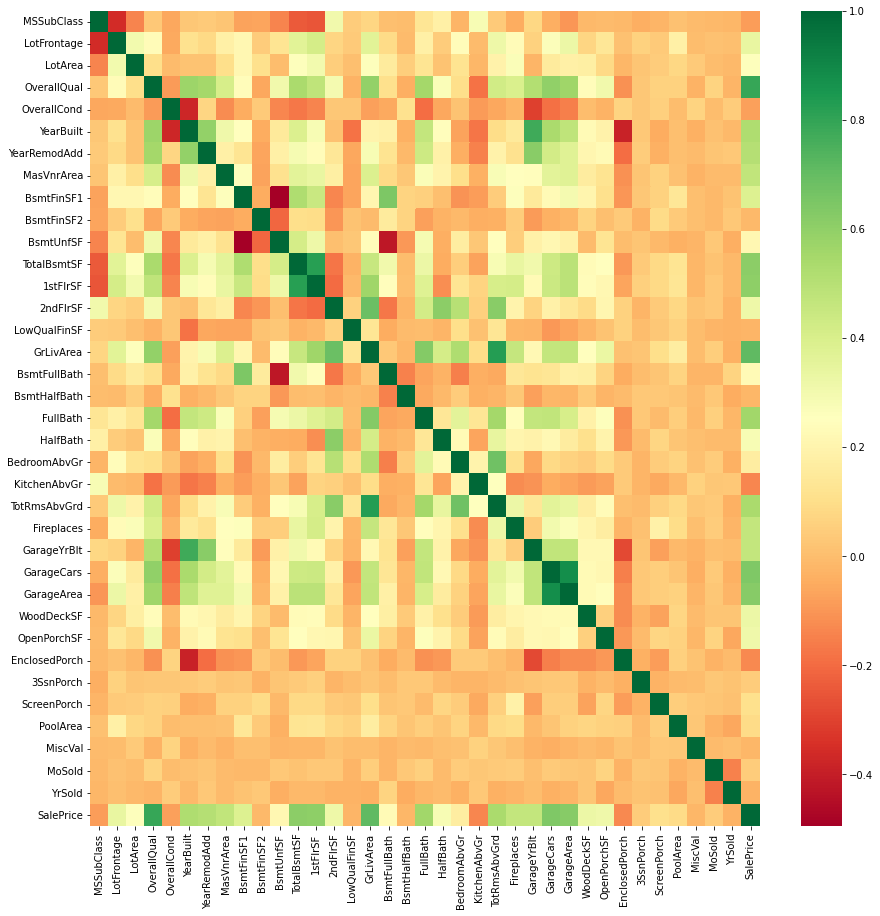

In [138]:
train_numeric['SalePrice'] = target
corr_matrix = train_numeric.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, cmap="RdYlGn")

**Insight. There are ~14 numeric features, highly correlated with the target**

In [139]:
corr_res = corr_filter(
    corr_matrix,
    target_feature='SalePrice',
    abs_thresh=0.4)

In [140]:
for feature_name, corr_coef in corr_res.items():
    print(feature_name, corr_coef)

OverallQual 0.7909816005838047
YearBuilt 0.5228973328794967
YearRemodAdd 0.5071009671113867
MasVnrArea 0.47261449900457725
TotalBsmtSF 0.6135805515591944
1stFlrSF 0.6058521846919166
GrLivArea 0.7086244776126511
FullBath 0.5606637627484452
TotRmsAbvGrd 0.5337231555820238
Fireplaces 0.4669288367515242
GarageYrBlt 0.4667536523633402
GarageCars 0.640409197258349
GarageArea 0.6234314389183598
SalePrice 1.0


## **1.4. Select K best categorical**

In [141]:
print_unique_dtypes(train)

{dtype('float64'), dtype('int64'), dtype('O')}


In [142]:
train_categorical = train.select_dtypes(include=['O'])
train_categorical.fillna("Missing", inplace=True)
train_categorical['SalePrice'] = target
train_categorical.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Missing,Attchd,RFn,TA,TA,Y,Missing,Missing,Missing,WD,Normal,208500
2,RL,Pave,Missing,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,Missing,Missing,Missing,WD,Normal,181500
3,RL,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,Missing,Missing,Missing,WD,Normal,223500
4,RL,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,Missing,Missing,Missing,WD,Abnorml,140000
5,RL,Pave,Missing,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,Missing,Missing,Missing,WD,Normal,250000


In [144]:
encoder = OrdinalEncoder()
encoder.fit(train_categorical)
train_categorical_enc = pd.DataFrame(encoder.transform(train_categorical))

In [146]:
train_categorical_enc.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
1455,3.0,1.0,1.0,3.0,3.0,0.0,4.0,0.0,8.0,2.0,2.0,0.0,5.0,1.0,1.0,12.0,13.0,3.0,3.0,4.0,2.0,2.0,4.0,4.0,6.0,6.0,1.0,0.0,1.0,5.0,3.0,6.0,5.0,1.0,2.0,5.0,5.0,2.0,3.0,2.0,1.0,8.0,4.0,314.0
1456,3.0,1.0,1.0,3.0,3.0,0.0,4.0,0.0,14.0,2.0,2.0,0.0,2.0,1.0,1.0,9.0,10.0,4.0,3.0,4.0,1.0,2.0,4.0,4.0,0.0,5.0,1.0,4.0,1.0,5.0,3.0,2.0,5.0,1.0,3.0,5.0,5.0,2.0,3.0,3.0,1.0,8.0,4.0,415.0
1457,3.0,1.0,1.0,3.0,3.0,0.0,4.0,0.0,6.0,2.0,2.0,0.0,5.0,1.0,1.0,5.0,5.0,3.0,0.0,2.0,4.0,4.0,1.0,4.0,2.0,6.0,1.0,0.0,1.0,5.0,2.0,6.0,2.0,1.0,2.0,5.0,5.0,2.0,3.0,0.0,3.0,8.0,4.0,527.0
1458,3.0,1.0,1.0,3.0,3.0,0.0,4.0,0.0,12.0,2.0,2.0,0.0,2.0,3.0,1.0,8.0,8.0,3.0,3.0,4.0,1.0,4.0,4.0,3.0,2.0,5.0,1.0,2.0,1.0,0.0,2.0,6.0,3.0,1.0,3.0,5.0,5.0,2.0,3.0,2.0,1.0,8.0,4.0,199.0
1459,3.0,1.0,1.0,3.0,3.0,0.0,4.0,0.0,7.0,2.0,2.0,0.0,2.0,1.0,1.0,6.0,6.0,3.0,2.0,4.0,1.0,4.0,4.0,4.0,1.0,3.0,1.0,2.0,1.0,5.0,3.0,6.0,3.0,1.0,0.0,5.0,5.0,2.0,3.0,2.0,1.0,8.0,4.0,221.0


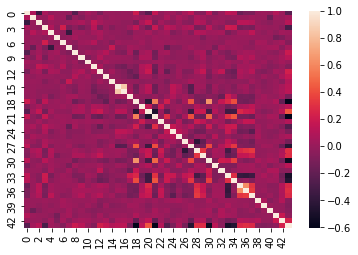

In [147]:
sns.heatmap(train_categorical_enc.corr())

#**2. Dataset clean (based on insights)**

#**3. Feature generation (based on insights)**